In [1]:
import requests
import requests.auth
import praw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# OAuth2 quick start

https://github.com/reddit-archive/reddit/wiki/OAuth2-Quick-Start-Example

In [2]:
# Load the credentials
credentials = {}
with open("credentials.txt", "r") as infile:
    for line in infile.readlines():
        key, val = line.strip().split(": ")
        credentials[key] = val

## Request a token

In [10]:
client_auth = requests.auth.HTTPBasicAuth(credentials["client_id"], credentials["secret"])
post_data = {"grant_type": "password", "username": credentials["username"], "password": credentials["password"]}
user_agent = f"reddit_api_python by {credentials['username']}"
headers = {"User-Agent": user_agent}
uri = "https://www.reddit.com/api/v1/access_token"
response = requests.post(uri, auth=client_auth, data=post_data, headers=headers)

## Use the token

In [13]:
auth = " ".join(response.json()[key] for key in ["token_type", "access_token"])
headers = {"Authorization": auth, "User-Agent": user_agent}
uri = "https://oauth.reddit.com/api/v1/me"
r = requests.get(uri, headers=headers)

# Start the Reddit API client

In [17]:
reddit = praw.Reddit(client_id=credentials["client_id"],
                     client_secret=credentials["secret"],
                     password=credentials["password"],
                     username=credentials["username"],
                     user_agent=user_agent)
reddit

## Search the subreddit

In [18]:
subreddit = reddit.subreddit("dataisbeautiful")
search_terms = ["sankey", "tinder", "budget", "monthly", "expenses", "lyrics"]
results = []
for query in search_terms:
    search = subreddit.search(query, sort="new", limit=None)
    results.extend(list(search))
    print(f"Found {len(results)} results for '{query}'.")

Found 83 results for 'sankey'.
Found 136 results for 'tinder'.
Found 318 results for 'budget'.
Found 538 results for 'monthly'.
Found 619 results for 'expenses'.
Found 708 results for 'lyrics'.


# Make a plot

In [19]:
posts = [r.__dict__ for r in results]
data = (pd.DataFrame(posts)
          .sort_values(by="created_utc", ascending=True)
          .drop_duplicates(subset="permalink"))

In [20]:
def term_is_in_comments(post, term):
    """Returns true if any comment in the post inclues the given term"""
    comments = post.comments.list()
    for comment in comments:
        if isinstance(comment, praw.models.reddit.more.MoreComments):
            comments.extend(comment.comments())
        elif term in comment.body.lower():
            print(comment.body)
            return True
    return False

In [21]:
def contains_same_topic(post, topic):
    """Checks if a given post contains the same topic as the specified post"""
    pass

In [23]:
def check_topics(post):
    topics = set()
    for term in search_terms:
        if term.lower() in post.title.lower():
            topics.add(term)
    return topics

In [24]:
def number_of_followup_posts(post, weeks_after_post=1):
    utc = post.created_utc
    window = weeks_after_post * 7 * 24 * 60 * 60 # convert to seconds
    mask = (data.created_utc > utc) & (data.created_utc <= (utc + window))
    
    # Check if the posts are actually follow ups
    original_topics = check_topics(post)
    if any(mask):
        followups = data[mask]
        return sum(followups.apply(check_topics, axis=1).apply(lambda x: len(x.intersection(original_topics)) > 0))
    else:
        return 0

In [25]:
%%time
data["number_of_followup_posts"] = data.apply(number_of_followup_posts, axis=1)

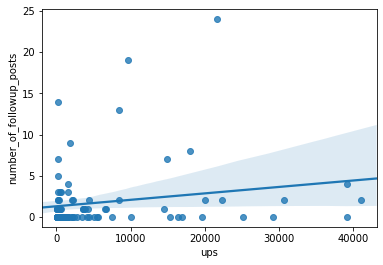

In [27]:
sns.regplot(data=data[data.ups >= 100], x="ups", y="number_of_followup_posts")

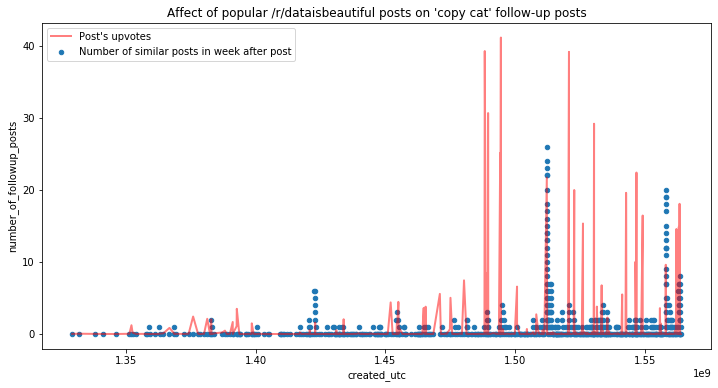

In [29]:
# mask = (data.created_utc > 1.47e9) & (data.ups > 50)
# mask = (data.created_utc > 1.51e9) & (data.ups >= 0) & (data.created_utc < 1.52e9)
ax = data.plot.scatter(*["created_utc", "number_of_followup_posts"], figsize=(12, 6))
ax.plot(data["created_utc"], data["ups"] / 1000, "r", alpha=0.5, linewidth=2)
ax.legend(["Post's upvotes", "Number of similar posts in week after post"])
ax.set_title("Affect of popular /r/dataisbeautiful posts on 'copy cat' follow-up posts")
# ax.set_xlim([1.51e9, 1.52e9])
plt.show()

In [26]:
N = 5
mask = data.ups >= 5
[print("reddit.com" + p) for p in data[mask].sort_values(by="number_of_followup_posts", ascending=False).head(N).permalink];

reddit.com/r/dataisbeautiful/comments/7hb299/our_monthly_budget_austin_tx_usa_oc/
reddit.com/r/dataisbeautiful/comments/7h99vj/where_my_monthly_paycheck_goes_japan_countryside/
reddit.com/r/dataisbeautiful/comments/7hajbn/where_my_monthly_income_goes_as_a_british_student/
reddit.com/r/dataisbeautiful/comments/7hasru/where_my_monthly_income_goes_as_a_single_parent/
reddit.com/r/dataisbeautiful/comments/bpof9r/how_a_monthly_belgian_household_budget_of_7350_is/
